In [121]:
import glob
# This file should run basically insta fast. Bad coding for sure 
# There is a place where i sometimes comment out lin/rbf/sigmoid stuff
# Dont do that, it really helps for some subjects. 
# Anything. Leave only linear. For fast testing of best features
# But dont do that either. 

genSavePath = "F:/PythonProjects/NietoExcercise-1/SavedResults/"
day = "12" # Which month and days result you want to visualize in table
month = 11

repetitionValue = 56
repetitionName =   "rndMlP3"  # "udrliplotnoAda3"  #  "udrlBC4CVTest" # 
#  "udrliplotnoAda3hyperparams" 
repetitionString = f"{repetitionValue}{repetitionName}"
curSavePath = f"{genSavePath}{day}-{month}-{repetitionString}/"
savedResults = glob.glob(curSavePath + "savedBestSeed*")

saveTop = True
if saveTop:
    saveTopName = "top2mlpudrlv.npy"
else:
    saveTopName = None
topAmount = 20
skipSubjects = []
onlySignificant = True
minAcc = 0.1
print(len(savedResults))
print(len(savedResults)/9)

7
0.7777777777777778


In [122]:
import pandas as pd
from array import ArrayType
from requests import delete
from tabulate import tabulate
from prettytable import PrettyTable as pt
import numpy as np


nameDict = dict()
nrOfNames = 0
kernelDict = dict()
nrOfKernel = 0
nrOfCombination = 0
currSeed = 0
currSubj = 0
combinationList = []
combinationResult = []


results = []
for path in savedResults:
    results.append(np.load(path, allow_pickle=True))

subjectAmount = 10
for x in range(subjectAmount):
    combinationResult.append([])

nrOfSeedsPerSubject = np.zeros(subjectAmount)
for s, subject in enumerate(results):
    currSubj = 0
    currSeed = 0
    subjectBestArray = np.empty([len(subject)], dtype=object)

    currSeed = subject[0]
    currSubj = subject[1]

    if currSubj in skipSubjects:
        continue
    nrOfSeedsPerSubject[currSubj] += 1

    for aResults in subject[2]:
        for aResults2 in aResults:
            # If the np array comes from svm results
            if len(aResults2) < 6:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                if ares > 0.98:
                    ares = 0.99
                akernel = aResults2[2]
                
                
                # if "lin" in akernel:
                #     continue
                # if "sig" in akernel:
                #     continue
                aC = round(aResults2[3], 2)

                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [nameDict[aName], kernelDict[akernel], aC] not in combinationList:
                    combinationList.append([nameDict[aName], kernelDict[akernel], aC])
                    nrOfCombination += 1

                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aC]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                    
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])

                    # If the np array comes from NN results
            else:

                aName = aResults2[0]
                ares = aResults2[1]

                if type(ares) is tuple:
                    ares = ares[0]
                akernel = aResults2[2]
                aLz = round(aResults2[3], 2)
                areg = round(aResults2[4], 2)
                adrp = round(aResults2[5], 2)
                if aName not in nameDict:
                    nameDict[aName] = nrOfNames
                    nrOfNames += 1
                if akernel not in kernelDict:
                    kernelDict[akernel] = nrOfKernel
                    nrOfKernel += 1
                if [
                    nameDict[aName],
                    kernelDict[akernel],
                    aLz,
                    areg,
                    adrp,
                ] not in combinationList:
                    combinationList.append(
                        [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                    )
                    nrOfCombination += 1
                # combResult = []
                combNr = combinationList.index(
                    [nameDict[aName], kernelDict[akernel], aLz, areg, adrp]
                )
                if any(combNr in sublist for sublist in combinationResult[currSubj]):
                    sublist = np.array(combinationResult[currSubj])
                  
                    index = int(np.where(sublist[:, 0] == combNr)[0])

                    combinationResult[currSubj][index][1] = combinationResult[currSubj][
                        index
                    ][1] * (1 - (1 / nrOfSeedsPerSubject[currSubj])) + ares * (
                        1 / nrOfSeedsPerSubject[currSubj]
                    )

                else:

                    combinationResult[currSubj].append([combNr, ares])


# Making table

# headers = [f"{x[0]}:{x[1]}:{x[2]}:" for x in combinationList]
headers = np.arange(nrOfCombination)
subjectResultArray = np.empty([10, nrOfCombination], dtype=object)
subjectNrList = []

comboAverage = np.zeros([1, nrOfCombination])
comboTotal = np.zeros([1, nrOfCombination])
nrOfSubjects = np.zeros(nrOfCombination)

topTen = []
topThreeAllSubjects = []
nameArray = np.array(list(nameDict))
topPerFeature = np.zeros([10, len(nameDict)])
lowestTopRes = [0, 0]
for subNr, cResult in enumerate(combinationResult):
    topThreeThisSubject = []
    resArray = np.zeros([nrOfCombination])
    if len(cResult) != 0:
        for res in cResult:
            if onlySignificant == True:
                if res[1] < minAcc:
                    continue
            comboAverage[0, res[0]] = comboAverage[0, res[0]] + res[1]
            comboTotal[0, res[0]] = comboTotal[0, res[0]] + res[1]
            nrOfSubjects[res[0]] += 1
            subjectResultArray[subNr, res[0]] = res[1]
            
            comboName = list(nameDict.keys())[combinationList[res[0]][0]]
            nameIndex = np.where(nameArray == comboName)[0][0]
            if res[1] > topPerFeature[subNr, nameIndex]:
                topPerFeature[subNr, nameIndex] = res[1]

            if len(topTen) < 10 or topTen[0][0] < res[1]:

                if len(topTen) == 10:
                    topTen.reverse()
                    topTen.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topTen.append([res[1], subNr, dataF, kernel, cVal])
                topTen.sort()

            
            
            if len(topThreeThisSubject) < 2 or topThreeThisSubject[0][0] < res[1]:

                if len(topThreeThisSubject) == 2:
                    topThreeThisSubject.reverse()
                    topThreeThisSubject.pop()

                dataF = list(nameDict.keys())[combinationList[res[0]][0]]
                kernel = list(kernelDict.keys())[combinationList[res[0]][1]]
                cVal = combinationList[res[0]][2]
                topThreeThisSubject.append([res[1], subNr, dataF, kernel, cVal])
                topThreeThisSubject.sort()
    if len(topThreeThisSubject)>0:
        topThreeAllSubjects.append(topThreeThisSubject)
# Print the table!
comboAverage = comboAverage / nrOfSubjects
print(comboAverage.shape)
print(subjectResultArray.shape)
pd.set_option("display.max_columns", None)

# For loop through zip of headers and columns,
# If column has all values == None, Remove column and header.
subjectResultArray = np.array(subjectResultArray)
emptyCols = []
atleastOneEmpty = False
for hcol, in zip(headers):
    if all(subjectResultArray[:,hcol] == None):
        atleastOneEmpty = True
        emptyCols.append(hcol)
if atleastOneEmpty: 
    subjectResultArray = np.delete(subjectResultArray, np.array(emptyCols),1)
    headers = np.delete(headers, np.array(emptyCols),0)
    comboAverage = np.delete(comboAverage, np.array(emptyCols),1)
    comboTotal = np.delete(comboTotal, np.array(emptyCols),1)
    nrOfSubjects = np.delete(nrOfSubjects, np.array(emptyCols),0)


table = pd.DataFrame(subjectResultArray, columns=headers)
display(table)




(1, 248)
(10, 248)


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247
0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,0.625,0.6,0.6,0.65,0.525,0.65,0.65,0.675,0.7,0.65,0.6,0.525,0.625,0.65,0.675,0.625,0.625,0.6,0.675,0.525,0.675,0.675,0.6,0.675,0.725,0.675,0.7,0.675,0.675,0.65,0.7,0.675,0.65,0.6,0.625,0.575,0.6,0.675,0.7,0.625,0.6,0.65,0.65,0.7,0.675,0.65,0.65,0.625,0.675,0.65,0.55,0.525,0.525,0.675,0.65,0.725,0.575,0.675,0.675,0.6,0.675,0.6,0.7,0.65,0.625,0.75,0.65,0.575,0.525,0.8,0.625,0.575,0.7,0.625,0.525,0.6,0.65,0.65,0.75,0.6,0.7,0.65,0.675,0.525,0.7,0.675,0.625,0.725,0.65,0.6,0.65,0.575,0.65,0.725,0.675,0.65,0.8,0.725,0.6,0.6,0.6,0.75,0.65,0.7,0.7,0.675,0.7,0.625,0.625,0.7,0.725,0.7,0.7,0.625,0.55,0.6,0.575,0.625,0.625,0.625,0.5,0.675,0.725,0.5,0.65,0.7,0.7,0.7,0.75,0.525,0.625,0.625,0.625,0.6,0.625,0.675,0.65,0.7,0.65,0.5,0.6,0.65,0.7,0.675,0.575,0.725,0.6,0.475,0.575,0.625,0.65,0.575,0.675,0.7,0.55,0.525,0.6,0.65,0.675,0.65,0.625,0.7,0.75,0.45,0.6,0.6,0.725,0.675,0.675,0.6,0.55,0.625,0.625,0.625,0.65,0.65,0.575,0.775,0.625,0.625,0.65,0.65,0.725,0.675,0.625,0.75,0.6,0.5,0.55,0.675,0.65,0.7,0.625,0.725,0.625,0.55,0.6,0.7,0.575,0.725,0.675,0.675,0.675,0.675,0.625,0.625,0.7,0.725,0.6,0.65,0.6,0.625,0.625,0.6,0.675,0.65,0.725,0.625,0.65,0.6,0.65,0.6,0.625,0.675,0.675,0.575,0.65,0.575,0.6,0.625,0.675,0.65,0.65,0.625,0.575,0.625,0.725,0.675,0.7,0.625,0.6,0.675,0.625,0.6,0.625,0.7,0.7,0.65
2,0.729167,0.8125,0.6875,0.8125,0.833333,0.770833,0.833333,0.708333,0.729167,0.708333,0.666667,0.6875,0.729167,0.75,0.770833,0.708333,0.770833,0.708333,0.708333,0.6875,0.708333,0.729167,0.8125,0.75,0.729167,0.708333,0.6875,0.791667,0.729167,0.729167,0.791667,0.770833,0.729167,0.791667,0.708333,0.770833,0.708333,0.770833,0.75,0.666667,0.791667,0.8125,0.791667,0.8125,0.791667,0.770833,0.770833,0.791667,0.770833,0.75,0.729167,0.666667,0.770833,0.729167,0.791667,0.729167,0.791667,0.729167,0.645833,0.770833,0.708333,0.666667,0.729167,0.770833,0.75,0.666667,0.6875,0.770833,0.7

In [123]:
x = 0

pd.set_option("display.max_columns", None)
print()
nameDictNrs = np.ones([1, len(nameDict)])
nameDictNrs[0,:] = np.arange(len(nameDict)) * 3
print(nameDictNrs.shape)
#table = pd.DataFrame(nameDictNrs , columns=nameDict.keys())
table = pd.DataFrame(topPerFeature, columns=nameDict.keys())
#display(table)
display(table)
# for names in nameDict.keys():
#     print(names, end="        ")
#     x +=1
#     #print(x)



(1, 248)


,dataFFTCV-BC-fftDataBC--dataCorr1dBC,dataFFTCV-BC-dataFFTCV-BC--fftDataBC,dataFFTCV-BC-welchDataBC--dataCorr2ax1d,dataFFTCV-BC-gaussianDataBC--dataCorr1dBC,dataFFTCV-BC-welchDataBC--iFFTdataCorr1d01s-BC,dataFFTCV-BC-fftDataBC--dataCorr2ax1dBC,dataFFTCV-BC-fftDataBC--dataHRBC,dataFFTCV-BC-fftDataBC--gaussianDataBC,dataWCV-BC-fftDataBC--dataCorr1dBC,dataWCV-BC-dataFFTCV-BC--fftDataBC,dataWCV-BC-welchDataBC--dataCorr2ax1d,dataWCV-BC-gaussianDataBC--dataCorr1dBC,dataWCV-BC-welchDataBC--iFFTdataCorr1d01s-BC,dataWCV-BC-fftDataBC--dataCorr2ax1dBC,dataWCV-BC-fftDataBC--dataHRBC,dataWCV-BC-fftDataBC--gaussianDataBC,dataHRCV-BC-fftDataBC--dataCorr1dBC,dataHRCV-BC-dataFFTCV-BC--fftDataBC,dataHRCV-BC-welchDataBC--dataCorr2ax1d,dataHRCV-BC-gaussianDataBC--dataCorr1dBC,dataHRCV-BC-welchDataBC--iFFTdataCorr1d01s-BC,dataHRCV-BC-fftDataBC--dataCorr2ax1dBC,dataHRCV-BC-fftDataBC--dataHRBC,dataHRCV-BC-fftDataBC--gaussianDataBC,fftDataBC-fftDataBC--dataCorr1dBC,fftDataBC-dataFFTCV-BC--fftDataBC,fftDataBC-welchDataBC--dataCorr2ax1d,fftDataBC-gaussianDataBC--dataCorr1dBC,fftDataBC-welchDataBC--iFFTdataCorr1d01s-BC,fftDataBC-fftDataBC--dataCorr2ax1dBC,fftDataBC-fftDataBC--dataHRBC,fftDataBC-fftDataBC--gaussianDataBC,welchDataBC-fftDataBC--dataCorr1dBC,welchDataBC-dataFFTCV-BC--fftDataBC,welchDataBC-welchDataBC--dataCorr2ax1d,welchDataBC-gaussianDataBC--dataCorr1dBC,welchDataBC-welchDataBC--iFFTdataCorr1d01s-BC,welchDataBC-fftDataBC--dataCorr2ax1dBC,welchDataBC-fftDataBC--dataHRBC,welchDataBC-fftDataBC--gaussianDataBC,dataHRBC-fftDataBC--dataCorr1dBC,dataHRBC-dataFFTCV-BC--fftDataBC,dataHRBC-welchDataBC--dataCorr2ax1d,dataHRBC-gaussianDataBC--dataCorr1dBC,dataHRBC-welchDataBC--iFFTdataCorr1d01s-BC,dataHRBC-fftDataBC--dataCorr2ax1dBC,dataHRBC-fftDataBC--dataHRBC,dataHRBC-fftDataBC--gaussianDataBC,dataGCVBC-fftDataBC--dataCorr1dBC,dataGCVBC-dataFFTCV-BC--fftDataBC,dataGCVBC-welchDataBC--dataCorr2ax1d,dataGCVBC-gaussianDataBC--dataCorr1dBC,dataGCVBC-welchDataBC--iFFTdataCorr1d01s-BC,dataGCVBC-fftDataBC--dataCorr2ax1dBC,dataGCVBC-fftDataBC--dataHRBC,dataGCVBC-fftDataBC--gaussianDataBC,gaussianDataBC-fftDataBC--dataCorr1dBC,gaussianDataBC-dataFFTCV-BC--fftDataBC,gaussianDataBC-welchDataBC--dataCorr2ax1d,gaussianDataBC-gaussianDataBC--dataCorr1dBC,gaussianDataBC-welchDataBC--iFFTdataCorr1d01s-BC,gaussianDataBC-fftDataBC--dataCorr2ax1dBC,gaussianDataBC-fftDataBC--dataHRBC,gaussianDataBC-fftDataBC--gaussianDataBC,dataCorr1dBC-fftDataBC--dataCorr1dBC,dataCorr1dBC-dataFFTCV-BC--fftDataBC,dataCorr1dBC-welchDataBC--dataCorr2ax1d,dataCorr1dBC-gaussianDataBC--dataCorr1dBC,dataCorr1dBC-welchDataBC--iFFTdataCorr1d01s-BC,dataCorr1dBC-fftDataBC--dataCorr2ax1dBC,dataCorr1dBC-fftDataBC--dataHRBC,dataCorr1dBC-fftDataBC--gaussianDataBC,inverseFFT-BC-fftDataBC--dataCorr1dBC,inverseFFT-BC-dataFFTCV-BC--fftDataBC,inverseFFT-BC-welchDataBC--dataCorr2ax1d,inverseFFT-BC-gaussianDataBC--dataCorr1dBC,inverseFFT-BC-welchDataBC--iFFTdataCorr1d01s-BC,inverseFFT-BC-fftDataBC--dataCorr2ax1dBC,inverseFFT-BC-fftDataBC--dataHRBC,inverseFFT-BC-fftDataBC--gaussianDataBC,iFFTdataCorr1d01s-BC-fftDataBC--dataCorr1dBC,iFFTdataCorr1d01s-BC-dataFFTCV-BC--fftDataBC,iFFTdataCorr1d01s-BC-welchDataBC--dataCorr2ax1d,iFFTdataCorr1d01s-BC-gaussianDataBC--dataCorr1dBC,iFFTdataCorr1d01s-BC-welchDataBC--iFFTdataCorr1d01s-BC,iFFTdataCorr1d01s-BC-fftDataBC--dataCorr2ax1dBC,iFFTdataCorr1d01s-BC-fftDataBC--dataHRBC,iFFTdataCorr1d01s-BC-fftDataBC--gaussianDataBC,iFFTdataCorr1d02s-BC-fftDataBC--dataCorr1dBC,iFFTdataCorr1d02s-BC-dataFFTCV-BC--fftDataBC,iFFTdataCorr1d02s-BC-welchDataBC--dataCorr2ax1d,iFFTdataCorr1d02s-BC-gaussianDataBC--dataCorr1dBC,iFFTdataCorr1d02s-BC-welchDataBC--iFFTdataCorr1d01s-BC,iFFTdataCorr1d02s-BC-fftDataBC--dataCorr2ax1dBC,iFFTdataCorr1d02s-BC-fftDataBC--dataHRBC,iFFTdataCorr1d02s-BC-fftDataBC--gaussianDataBC,iFFTdataCorr1d005s-BC-fftDataBC--dataCorr1dBC,iFFTdataCorr1d005s-BC-dataFFTCV-BC--fftDataBC,iFFTdataCorr1d005s-BC-welchDataBC--dataCorr2ax1d,iFFTdataCorr1d005s-BC-gaussianDataBC--

(248,)



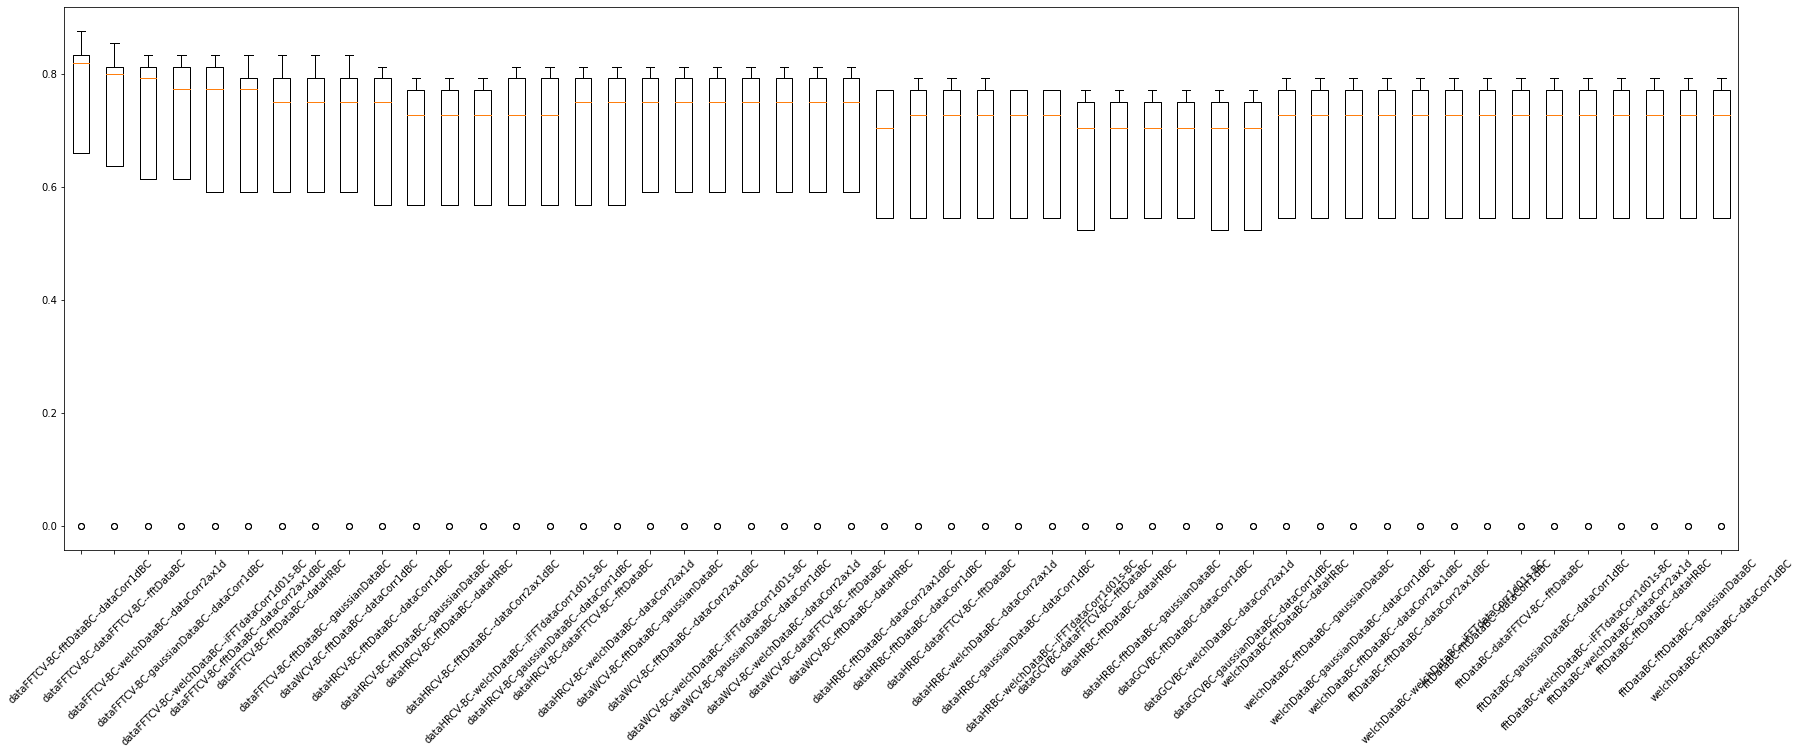

In [124]:
import matplotlib.pyplot as plt
# ordeTopAverage = np.array(np.argsort(comboAverage, axis=1)/(len(combinationList))*len(dataF),dtype=int)
# print(ordeTopAverage)
# print(len(combinationList))
# print(len(dataF))
# print(len(topPerFeature))
# print(len(combinationList)/len(dataF))
#print(ordeTopAverage)

topPerFeature = np.sort(topPerFeature, axis=1)[:,::-1]
indices = np.argsort(topPerFeature, axis=1)[:,::-1][1,:]
print(indices.shape)

#np.argsort(comboAverage, axis=1)
#sortA = np.argsort(topPerFeature, axis = 1)
if len(nameArray) < 100:
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:])
    plt.xticks(np.arange(len(nameArray))+1,nameArray,rotation=45)
    #plt.legend(nameArray)
    print("")
else: 
    plt.figure(figsize=[30,10])
    plt.boxplot(topPerFeature[1:, indices][:,:50])
    plt.xticks(np.arange(len(nameArray[indices][:50]))+1,nameArray[indices][:50],rotation=45)
    #plt.legend(nameArray)
    print("")
    


In [125]:
print("Top ten highest accuracies")

topTen.reverse()
for top in topTen:
    print(
            f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
        )


Top ten highest accuracies
Accuracy 0.88 : subject 2, feature:inverseFFT-BC-fftDataBC--dataCorr1dBC, kernelgini, C:1
Accuracy 0.85 : subject 4, feature:welchDatacn3BC-gaussianDataBC--dataCorr1dBC, kernelgini, C:1
Accuracy 0.85 : subject 2, feature:dataCorr2ax1d-fftDataBC--gaussianDataBC, kernelgini, C:1
Accuracy 0.83 : subject 2, feature:iFFTdataCorr1d02s-BC-fftDataBC--dataHRBC, kernelgini, C:1
Accuracy 0.83 : subject 2, feature:dataWCV-BCcn3-fftDataBC--dataHRBC, kernelgini, C:1
Accuracy 0.83 : subject 2, feature:dataFFTCV-BC-welchDataBC--iFFTdataCorr1d01s-BC, kernelgini, C:1
Accuracy 0.83 : subject 2, feature:dataFFTCV-BC-fftDataBC--dataHRBC, kernelgini, C:1
Accuracy 0.83 : subject 2, feature:dataCorr2ax1dBC-welchDataBC--dataCorr2ax1d, kernelgini, C:1
Accuracy 0.83 : subject 2, feature:dataCorr1dcn3-fftDataBC--dataCorr2ax1dBC, kernelgini, C:1
Accuracy 0.83 : subject 2, feature:dataCorr1d01sBC-welchDataBC--dataCorr2ax1d, kernelgini, C:1


In [126]:
# top for each feature

In [127]:
print("Top ten highest accuracies")
#del(topThreeThisSubject[0])
#len(topThreeAllSubjects[0])
for subTop in topThreeAllSubjects:
    subTop.reverse()
topThreeAllSubjects.sort(reverse=True)
arrayOfTopFeatureNames = []
for subTop in topThreeAllSubjects:
    print("")
    #subTop.reverse()
    for top in subTop[:1]:
        arrayOfTopFeatureNames.append(top[2])
        print(
                f"Accuracy {round(top[0],2)} : subject {top[1]}, feature:{top[2]}, kernel{top[3]}, C:{top[4]}"
            )
#print(arrayOfTopFeatureNames)
arrayOfTopFeatureNames = np.array(arrayOfTopFeatureNames, dtype=object)
#print(np.array(arrayOfTopFeatureNames, dtype=object).shape)
newArrayOfTopFeatureNames = []
for topNames in arrayOfTopFeatureNames:
    temp = topNames.replace("--","-")
    temp2 = temp.replace("-B","%")
    splitArray = np.array(temp2.split("-"),dtype=object)
    for ind, stri in enumerate(splitArray):
        splitArray[ind] = stri.replace("%","-B")
    skip = False  
    for obj in splitArray:
        #print(obj)
        if obj == "":
            #print("aofafa")
            skip = True
    if skip:
        continue
    #print(splitArray)
    newArrayOfTopFeatureNames.append(splitArray)
    
#print(newArrayOfTopFeatureNames)
newArrayOfTopFeatureNames = np.array(newArrayOfTopFeatureNames, dtype=object) 
#saveTopName = "top2udrli"
if saveTopName is not None:
    #print(newArrayOfTopFeatureNames)
    np.save(f"topFeatures/{saveTopName}", newArrayOfTopFeatureNames)
    print("TopFeatureNameArraySaved")
    print(newArrayOfTopFeatureNames)


Top ten highest accuracies

Accuracy 0.88 : subject 2, feature:inverseFFT-BC-fftDataBC--dataCorr1dBC, kernelgini, C:1

Accuracy 0.85 : subject 4, feature:welchDatacn3BC-gaussianDataBC--dataCorr1dBC, kernelgini, C:1

Accuracy 0.83 : subject 7, feature:welchDatacn3BC-fftDataBC--dataCorr2ax1dBC, kernelgini, C:1

Accuracy 0.83 : subject 5, feature:dataCorr2ax1dBC-dataFFTCV-BC--fftDataBC, kernelgini, C:1

Accuracy 0.82 : subject 6, feature:dataFFTCV-BC-welchDataBC--dataCorr2ax1d, kernelgini, C:1

Accuracy 0.8 : subject 1, feature:iFFTdataCorr1d005s-BC-fftDataBC--dataCorr1dBC, kernelgini, C:1

Accuracy 0.66 : subject 3, feature:welchDatacn3BC-fftDataBC--gaussianDataBC, kernelgini, C:1
TopFeatureNameArraySaved
[['inverseFFT-BC' 'fftDataBC' 'dataCorr1dBC']
 ['welchDatacn3BC' 'gaussianDataBC' 'dataCorr1dBC']
 ['welchDatacn3BC' 'fftDataBC' 'dataCorr2ax1dBC']
 ['dataCorr2ax1dBC' 'dataFFTCV-BC' 'fftDataBC']
 ['dataFFTCV-BC' 'welchDataBC' 'dataCorr2ax1d']
 ['iFFTdataCorr1d005s-BC' 'fftDataBC' 'data

In [128]:
subjAv = np.zeros(subjectResultArray.shape[0])
for s, subj in enumerate(subjectResultArray):
    subjAv[s] = 0
    if all(subj == None):
        continue
    subjAv[s] = np.mean(subj[np.where(subj != None)])
print(subjAv)
pd.set_option("display.max_columns", None)
table = pd.DataFrame(np.array(comboAverage), columns=headers)
display(table)

print(
    f"Max average accuracy {np.max(np.array(comboAverage[np.where(np.isnan(comboAverage)==False)]))}"
)
maxVal = np.max(np.array(comboAverage[np.where(np.isnan(comboAverage) == False)]))
maxInd = int(np.where(comboAverage == maxVal)[1][0])
# print(headers[maxInd])
# print(nrOfSubjects[maxInd])
# print(list(nameDict.keys())[combinationList[maxInd][0]])
# print(list(kernelDict.keys())[combinationList[maxInd][1]])
# print(f"C: {combinationList[maxInd][2]}")


[0.         0.64153226 0.74050739 0.47718109 0.68237567 0.72992272
 0.6809934  0.7155578  0.         0.        ]


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247
0,0.656115,0.676894,0.657413,0.617208,0.659957,0.681602,0.671861,0.672998,0.683063,0.684307,0.671753,0.587446,0.640693,0.684848,0.67868,0.671807,0.689935,0.666342,0.688149,0.587446,0.663799,0.651353,0.692045,0.679221,0.695563,0.673539,0.680087,0.693831,0.655411,0.66645,0.722024,0.69789,0.677814,0.698539,0.662067,0.664935,0.64118,0.665963,0.673323,0.665855,0.661472,0.662121,0.682143,0.660877,0.669751,0.674297,0.655628,0.664232,0.672186,0.684578,0.642965,0.574729,0.679437,0.667587,0.659416,0.68934,0.641937,0.715747,0.672186,0.583009,0.67868,0.650379,0.679004,0.691071,0.668561,0.665855,0.657251,0.591071,0.639665,0.714123,0.665855,0.667641,0.688203,0.67776,0.660498,0.625758,0.682684,0.665639,0.674784,0.669318,0.689015,0.681061,0.666504,0.615314,0.682792,0.680574,0.668831,0.688258,0.694048,0.675,0.675379,0.597024,0.659957,0.69881,0.668398,0.678084,0.691667,0.704221,0.640909,0.606277,0.650379,0.708604,0.693506,0.697673,0.680357,0.675433,0.687933,0.617154,0.653409,0.678734,0.663366,0.665206,0.664123,0.680736,0.6454,0.627652,0.667641,0.683171,0.652056,0.65368,0.679654,0.691126,0.682576,0.604708,0.678355,0.666558,0.690368,0.685227,0.683442,0.659416,0.659361,0.607143,0.665855,0.646861,0.648539,0.691126,0.672403,0.713907,0.684578,0.583874,0.664719,0.672673,0.666558,0.673539,0.661959,0.692316,0.674459,0.613853,0.664123,0.675054,0.678084,0.673593,0.67868,0.691721,0.676786,0.635606,0.668506,0.691071,0.663258,0.694048,0.656656,0.648972,0.667749,0.567262,0.647403,0.671483,0.686093,0.669481,0.665963,0.653626,0.657846,0.642587,0.665584,0.680465,0.659416,0.651028,0.661688,0.689989,0.647186,0.625541,0.678896,0.681061,0.706926,0.697619,0.675866,0.689935,0.671212,0.546807,0.660552,0.681656,0.671861,0.697132,0.659361,0.705574,0.671266,0.633225,0.659578,0.68658,0.652219,0.683117,0.672186,0.688149,0.686797,0.671645,0.692641,0.655303,0.685227,0.685552,0.683929,0.693777,0.692587,0.705357,0.679654,0.69881,0.705736,0.71921,0.689069,0.653409,0.661039,0.613853,0.660498,0.65579,0.650703,0.685173,0.679491,0.637338,0.635065,0.606494,0.637933,0.683171,0.687338,0.66645,0.671861,0.656656,0.646537,0.657197,0.655249,0.662446,0.685227,0.67776,0.66553,0.68869,0.683983,0.616288,0.663149,0.653842,0.684416,0.677543


Max average accuracy 0.7220238095238096


In [129]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboAverage.argsort()[0][-5:][::-1]]
top5Vals = comboAverage[0][comboAverage.argsort()[0][-5:][::-1]]
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC-fftDataBC--dataHRBC
gini
0.7220238095238096

welchDatacn3BC-fftDataBC--gaussianDataBC
gini
0.7192099567099567

gaussianDataBC-dataFFTCV-BC--fftDataBC
gini
0.7157467532467533

dataCorr1dBC-fftDataBC--dataCorr2ax1dBC
gini
0.7141233766233767

dataCorr2ax1dBC-dataFFTCV-BC--fftDataBC
gini
0.7139069264069265



In [130]:
#np.argpartition(comboAverage, -4)
#print(headers[comboAverage.argsort()[0][-5:][::-1]])
top5 = headers[comboTotal.argsort()[0][-5:][::-1]]
top5Vals = comboTotal[0][comboTotal.argsort()[0][-5:][::-1]] /9
for maxInd,res in zip(top5, top5Vals):
    print(list(nameDict.keys())[combinationList[maxInd][0]])
    print(list(kernelDict.keys())[combinationList[maxInd][1]])
    print(res)
    print()

fftDataBC-fftDataBC--dataHRBC
gini
0.5615740740740741

welchDatacn3BC-fftDataBC--gaussianDataBC
gini
0.5593855218855218

gaussianDataBC-dataFFTCV-BC--fftDataBC
gini
0.5566919191919193

dataCorr1dBC-fftDataBC--dataCorr2ax1dBC
gini
0.555429292929293

dataCorr2ax1dBC-dataFFTCV-BC--fftDataBC
gini
0.5552609427609428



In [131]:
table = pd.DataFrame(np.array(comboTotal), columns=headers)
display(table)

maxVal2 = np.max(np.array(comboTotal[np.where(np.isnan(comboTotal) == False)]))

for maxInd2 in np.where(comboTotal == maxVal2)[1]:

    # maxInd2 = int(np.where(comboTotal == maxVal2)[1])
    print(headers[maxInd2])
    print(nrOfSubjects[maxInd2])
    print(
        f"Max total significant accuracy then averaged {maxVal2/nrOfSubjects[maxInd2]} "
    )

    print(list(nameDict.keys())[combinationList[maxInd2][0]])
    print(list(kernelDict.keys())[combinationList[maxInd2][1]])
    print(f"C: {combinationList[maxInd2][2]} ")


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247
0,4.592803,4.738258,4.601894,4.320455,4.619697,4.771212,4.70303,4.710985,4.781439,4.790152,4.702273,4.112121,4.484848,4.793939,4.750758,4.702652,4.829545,4.664394,4.817045,4.112121,4.646591,4.55947,4.844318,4.754545,4.868939,4.714773,4.760606,4.856818,4.587879,4.665152,5.054167,4.885227,4.744697,4.889773,4.63447,4.654545,4.488258,4.661742,4.713258,4.660985,4.630303,4.634848,4.775,4.626136,4.688258,4.720076,4.589394,4.649621,4.705303,4.792045,4.500758,4.023106,4.756061,4.673106,4.615909,4.825379,4.493561,5.010227,4.705303,4.081061,4.750758,4.552652,4.75303,4.8375,4.679924,4.660985,4.600758,4.1375,4.477652,4.998864,4.660985,4.673485,4.817424,4.744318,4.623485,4.380303,4.778788,4.65947,4.723485,4.685227,4.823106,4.767424,4.66553,4.307197,4.779545,4.764015,4.681818,4.817803,4.858333,4.725,4.727652,4.179167,4.619697,4.891667,4.678788,4.746591,4.841667,4.929545,4.486364,4.243939,4.552652,4.960227,4.854545,4.883712,4.7625,4.72803,4.81553,4.320076,4.573864,4.751136,4.643561,4.656439,4.648864,4.765152,4.517803,4.393561,4.673485,4.782197,4.564394,4.575758,4.757576,4.837879,4.77803,4.232955,4.748485,4.665909,4.832576,4.796591,4.784091,4.615909,4.61553,4.25,4.660985,4.52803,4.539773,4.837879,4.706818,4.997348,4.792045,4.087121,4.65303,4.708712,4.665909,4.714773,4.633712,4.846212,4.721212,4.29697,4.648864,4.725379,4.746591,4.715152,4.750758,4.842045,4.7375,4.449242,4.679545,4.8375,4.642803,4.858333,4.596591,4.542803,4.674242,3.970833,4.531818,4.700379,4.802652,4.686364,4.661742,4.575379,4.604924,4.498106,4.659091,4.763258,4.615909,4.557197,4.631818,4.829924,4.530303,4.378788,4.752273,4.767424,4.948485,4.883333,4.731061,4.829545,4.698485,3.827652,4.623864,4.771591,4.70303,4.879924,4.61553,4.939015,4.698864,4.432576,4.617045,4.806061,4.56553,4.781818,4.705303,4.817045,4.807576,4.701515,4.848485,4.587121,4.796591,4.798864,4.7875,4.856439,4.848106,4.9375,4.757576,4.891667,4.940152,5.03447,4.823485,4.573864,4.627273,4.29697,4.623485,4.59053,4.554924,4.796212,4.756439,4.461364,4.445455,4.245455,4.46553,4.782197,4.811364,4.665152,4.70303,4.596591,4.525758,4.600379,4.586742,4.637121,4.796591,4.744318,4.658712,4.820833,4.787879,4.314015,4.642045,4.576894,4.790909,4.742803


30
7.0
Max total significant accuracy then averaged 0.7220238095238096 
fftDataBC-fftDataBC--dataHRBC
gini
C: 1 


In [132]:
# maxAcc = np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])])
# print(f"Max single accuracy position {np.where(subjectResultArray == maxAcc)}")
# print(np.max([res for res in np.array(
#     subjectResultArray[subjectResultArray != None])]))
